In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy 
datos, metadatos = tfds.load("fashion_mnist", as_supervised=True, with_info=True)

metadatos

datos_entrenamiento, datos_pruebas = datos["train"], datos["test"]


In [2]:
nombres_clases = metadatos.features["label"].names

nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [23]:
#Normalizar datos (pasar de 0-255 px a 0-1)

def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255 #Aqui lo pasamos de 0-255 a 0-1
    return imagenes, etiquetas

#Normalizar los datos de entrenamientos y pruebas con la funcion que ya hice aqui arriba 

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Ahora guardo los datos en cache (para asi utilizar menos memoria en lugar de disco, y tambien obtengo entrenamiento mas rapido)

datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

<function matplotlib.pyplot.show(close=None, block=None)>

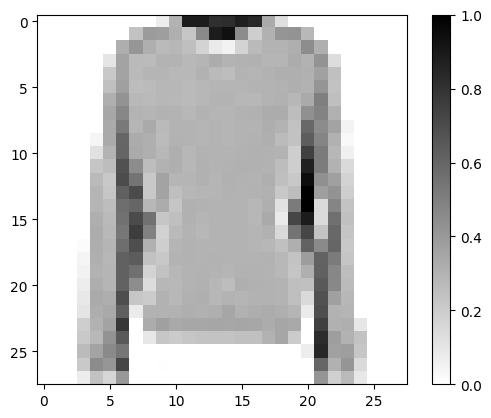

In [24]:
#Mostrar imagen para garantizar que el codigo funcione bien 

for imagen, etiqueta in datos_entrenamiento.take(1):
    break
imagen = imagen.numpy().reshape((28,28)) #Rendimensiono la imagen (tensores)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show



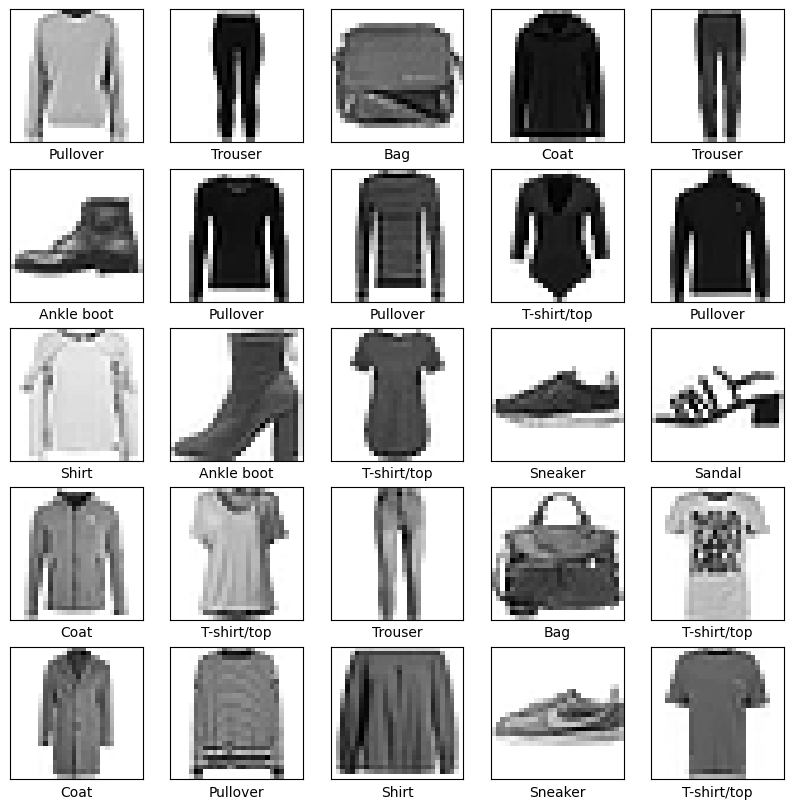

In [25]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    imagen = imagen.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen, cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[int(etiqueta.numpy())])  
plt.show()


In [26]:
#Crear el modelo

modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 blanco y negro
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Redes de clasificacion 
])

C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
modelo.compile(
    optimizer= "adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [28]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [29]:
TAMANO_LOTE = 32

# Barajamos, repetimos y dividimos en lotes
datos_entrenamiento = datos["train"].shuffle(num_ej_entrenamiento).repeat().batch(TAMANO_LOTE)
datos_pruebas = datos["test"].batch(TAMANO_LOTE)

print("Preparación de datos lista ✅")


Preparación de datos lista ✅


In [30]:
import math

# Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6588 - loss: 6.0641
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7848 - loss: 0.6635
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8155 - loss: 0.5604
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8191 - loss: 0.5460
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8312 - loss: 0.4971


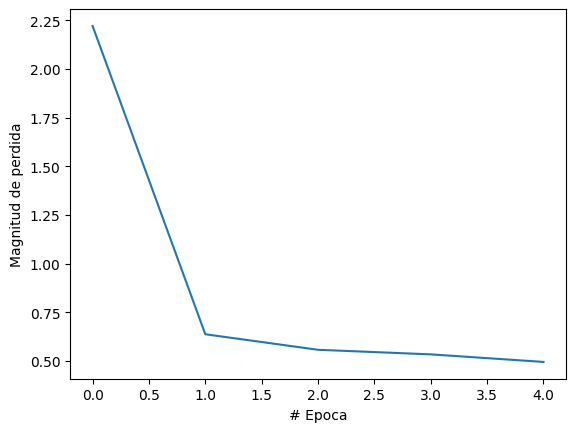

In [32]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


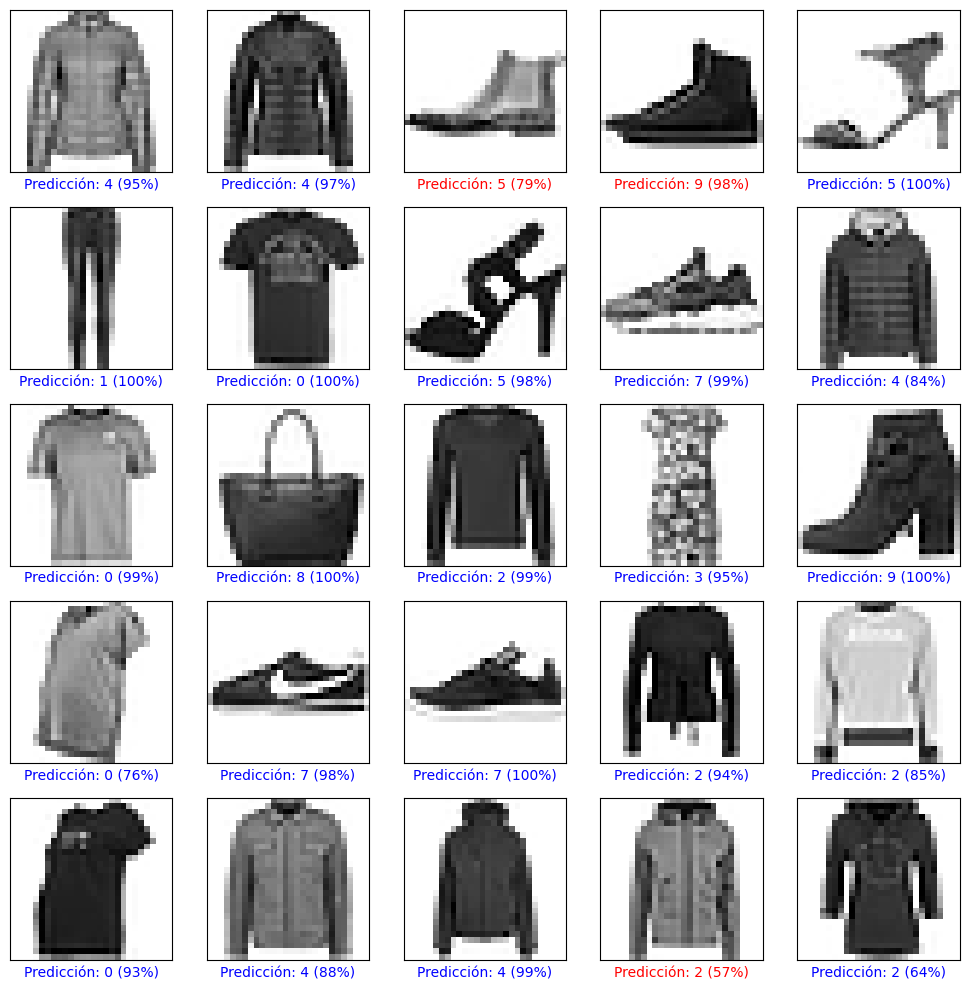

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Tomamos solo 1 lote de datos de prueba
for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
    imagenes_prueba = imagenes_prueba.numpy()
    etiquetas_prueba = etiquetas_prueba.numpy()
    predicciones = modelo.predict(imagenes_prueba)

# Función para graficar la imagen
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
    arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[..., 0], cmap=plt.cm.binary) # Imagen en blanco y negro

    etiqueta_prediccion = np.argmax(arr_predicciones)
    color = 'blue' if etiqueta_prediccion == etiqueta_real else 'red'
    plt.xlabel(f"Predicción: {etiqueta_prediccion} ({100*np.max(arr_predicciones):2.0f}%)", color=color)

# Graficamos las primeras 10 imágenes
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)

plt.tight_layout()
plt.show()


In [34]:
modelo.save("modelo_exportado.h5")


In [49]:
!tensorflowjs_converter --input_format keras tu_modelo.h5 modelo/


2025-03-07 13:20:56.527113: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages